In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer, euclidean_distance
import string
from sklearn.manifold import TSNE
import json

In [2]:
with open('../secrets.json') as file:
    secrets = json.load(file)
    connection_string = secrets['connection_string']
db = create_engine(connection_string)
df = pd.read_sql('SELECT * FROM NAP.article', con=db)

df

,id,post_id,post_title,url,score,publisher,headline,date_published,content
0,1,fra8wl,Top US general resists Trump administration?s ...,https://mondoweiss.net/2020/03/top-u-s-general...,10285,mondoweiss,Top U.S. general resists Trump administration?...,2020-03-28 15:44:00,A brave U.S. army lieutenant general may be ri...
1,2,frcvgj,Experts believe the explosion of coronavirus c...,https://www.si.com/soccer/2020/03/25/atalanta-...,2854,si,Atalanta vs Valencia linked to accelerating co...,2020-03-25 00:00:00,ROME (AP) ? It was the biggest soccer game in ...
2,3,fr5uqd,Boris Johnson's government is reportedly furio...,https://www.businessinsider.com/coronavirus-bo...,79397,businessinsider,Boris Johnson's government is reportedly furio...,2020-03-29 00:00:00,"UK government officials say there'll be ""recko..."
3,4,fr7uzc,Toyota Gearing Up To Build Ventilators And Fac...,https://www.carscoops.com/2020/03/toyota-geari...,4988,carscoops,Toyota Gearing Up To Build Ventilators And Fac...,2020-03-27 22:36:00,"The United States will soon have over 100,000 ..."
4,5,frbkqr,Prime Minister Justin Trudeau says Health Cana...,https://www.ctvnews.ca/health/coronavirus/trud...,2341,ctvnews,Trudeau vows 'no corners cut' in accepting mas...,2020-03-29 13:04:00,TORONTO -- Prime Minister Justin Trudeau says ...
...,...,...,...,...,...,...,...,...,...
867,884,gfbygc,A Broadband Engineer Was Spat on by a 5G Consp...,https://www.vice.com/en_us/article/4ayg8g/a-br...,43453,vice,A Broadband Engineer Was Spat on by a 5G Consp...,2020-05-07 15:16:09,Want the best of VICE News straight to your in...
868,885,gf8z7p,Taiwan refuses to deport caregiver who ‘insult...,https://globalvoices.org/2020/05/07/taiwan-ref...,4066,globalvoices,Taiwan refuses to deport caregiver who ‘insult...,2020-05-07 00:00:00,Taiwan has rejected the request of a Philippin...
869,886,gfb7eu,Sweden admits a 'big failure' to prevent elder...,https://www.msn.com/en-gb/health/medical/swede...,2208,msn,Sweden admits a 'big failure' to prevent elder...,None,© Getty The Swedish flag in Gothenburg The num...
870,887,gfe0g8,Trump says he's sending ventilators to Russia ...,https://www.businessinsider.com/trump-is-givin...,992,businessinsider,Trump says he's sending ventilators to Russia ...,2020-05-07 00:00:00,President Donald Trump said he would send vent...


In [3]:
df.iloc[-1, 3]

'https://www.thestar.com/news/canada/2020/05/06/trudeau-warns-of-severe-penalties-after-fourth-cellphone-tower-torched-in-quebec.html'

# Clustering content of articles

The first step is to use word2vec to get a numeric representation of the text data. This converts words into a vector. Based on the context of the words, similar words will have similar vectors.

Combine all the articles. I'm looking for overall patterns, so I want to see relationships across articles.

In [4]:
article_content = ''
for i in range(len(df)):
    article_content += df.iloc[i]['content'].lower()

In [5]:
# article = df.iloc[0]['content'].lower()

# tokenize into sentences then words
sent_tokens = sent_tokenize(article_content)
sents = [nltk.word_tokenize(s) for s in sent_tokens]

# remove stop words and tokens that are just punctuation
stop_words = set(stopwords.words('english')) 
for i, sent in enumerate(sents):
    new_sent = [word for word in sent if word not in stop_words and word not in string.punctuation]
    sents[i] = new_sent

# create a word vector - word must be used at least five times be a word vector
vec = Word2Vec(sents, min_count=5)

View the vocabulary

In [6]:
vec.wv.vocab

{'brave': <gensim.models.keyedvectors.Vocab at 0x1590d16fd88>,
 'u.s.': <gensim.models.keyedvectors.Vocab at 0x1590d16f488>,
 'army': <gensim.models.keyedvectors.Vocab at 0x1590d16f548>,
 'lieutenant': <gensim.models.keyedvectors.Vocab at 0x1590d16f5c8>,
 'general': <gensim.models.keyedvectors.Vocab at 0x1590d16f888>,
 'may': <gensim.models.keyedvectors.Vocab at 0x1590d16f988>,
 'career': <gensim.models.keyedvectors.Vocab at 0x1590d16fa08>,
 'resist': <gensim.models.keyedvectors.Vocab at 0x1590d16fa88>,
 'trump': <gensim.models.keyedvectors.Vocab at 0x1590d16f748>,
 'administration': <gensim.models.keyedvectors.Vocab at 0x1590d16f8c8>,
 'efforts': <gensim.models.keyedvectors.Vocab at 0x1590d16fac8>,
 'war': <gensim.models.keyedvectors.Vocab at 0x1590d16f088>,
 'iran': <gensim.models.keyedvectors.Vocab at 0x1590d16f108>,
 'robert': <gensim.models.keyedvectors.Vocab at 0x1590d16f2c8>,
 'p.': <gensim.models.keyedvectors.Vocab at 0x1590d16f348>,
 'white': <gensim.models.keyedvectors.Vocab 

Just looking through the vocabulary from above, I looked up some words to see what other words were seen as similar.

In [7]:
vec.wv.most_similar('world')

[('organization', 0.902938961982727),
 ('organisation', 0.8280209898948669),
 ('public', 0.8124655485153198),
 ('crisis', 0.7944079637527466),
 ('global', 0.7937381863594055),
 ('health', 0.7893438339233398),
 ('iq', 0.7733420729637146),
 ('economic', 0.7674145698547363),
 ('mental', 0.7600283622741699),
 ('firebreaks', 0.7589467763900757)]

In [8]:
vec.wv.most_similar('virus')

[('disease', 0.9798688888549805),
 ('covid-19', 0.9786722660064697),
 ('coronavirus', 0.963925302028656),
 ('infected', 0.9595301151275635),
 ('patients', 0.9577029943466187),
 ('positive', 0.9563300609588623),
 ('novel', 0.9555969834327698),
 ('120,000', 0.9553700685501099),
 ('tested', 0.9390104413032532),
 ('spread', 0.9377150535583496)]

In [9]:
vec.wv.most_similar('technology')

[('using', 0.9991596937179565),
 ('role', 0.9991245269775391),
 ('challenge', 0.9987475872039795),
 ('claims', 0.9987087249755859),
 ('surveillance', 0.9986825585365295),
 ('scientific', 0.9986639022827148),
 ('responsible', 0.9986388087272644),
 ('debate', 0.9985794425010681),
 ('toward', 0.9985653162002563),
 ('attempts', 0.9985508322715759)]

In [10]:
vec.wv.most_similar('tracking')

[('successful', 0.9990999698638916),
 ('strain', 0.9990646839141846),
 ('resulted', 0.9990545511245728),
 ('detect', 0.9990537762641907),
 ('rapidly', 0.9990429878234863),
 ('largely', 0.9989633560180664),
 ('•', 0.9989472031593323),
 ('alarm', 0.9989343881607056),
 ('huanan', 0.99889075756073),
 ('curve', 0.9988784790039062)]

Word vectors are 100-dimensional, so I have to use the TSNE class from scikit-learn to convert them to 2-dimensions for visualization.

In [11]:
vec.wv.__getitem__('world')

array([-0.7519905 , -0.5150246 , -0.148752  , -0.39874196, -0.6500879 ,
        0.4669024 , -0.5920085 , -0.4566658 , -0.44660732,  0.6577951 ,
       -0.683938  ,  0.5897489 , -0.44068587, -0.2198608 , -1.4359463 ,
        0.4689164 ,  0.41105354, -0.4791411 ,  0.6989519 , -0.06606851,
        0.01671975,  1.0966703 , -0.3671338 , -0.02010861,  0.84783614,
        0.46727765, -0.34851265, -0.7819059 ,  1.1007428 ,  0.23918328,
        0.8133936 , -0.6384028 ,  0.7016835 ,  0.68076974, -0.86506397,
       -0.5204158 , -1.128332  ,  0.21629411, -0.05818268,  0.5272523 ,
        0.6977067 , -0.780031  ,  0.53634554,  0.76983297,  0.08151963,
       -0.3818126 ,  0.21361777, -0.1181236 , -0.00867037, -0.10708731,
       -0.5260285 ,  0.5324629 ,  0.32832217, -0.40684167,  0.79466003,
        0.89557904,  0.4637998 , -0.6144046 , -0.86551684,  0.52837515,
        0.5329848 ,  0.20118178,  0.05676682,  0.15183379,  0.2490792 ,
       -0.02909416, -0.7263958 , -0.67941946, -0.5188762 ,  0.05

In [12]:
vectors = [vec.wv.__getitem__(word) for word in vec.wv.vocab]

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=17)
coords = tsne_model.fit_transform(vectors)

In [13]:
coords

array([[ -41.507225 ,  -20.317947 ],
       [ 124.3812   ,   20.654633 ],
       [ 100.2728   ,  -22.451004 ],
       ...,
       [-106.00634  ,  -18.839815 ],
       [  27.764126 ,   48.92387  ],
       [ -42.810947 ,    7.5593185]], dtype=float32)

In [14]:
xs = []
ys = []

for coord in coords:
    xs.append(coord[0])
    ys.append(coord[1])

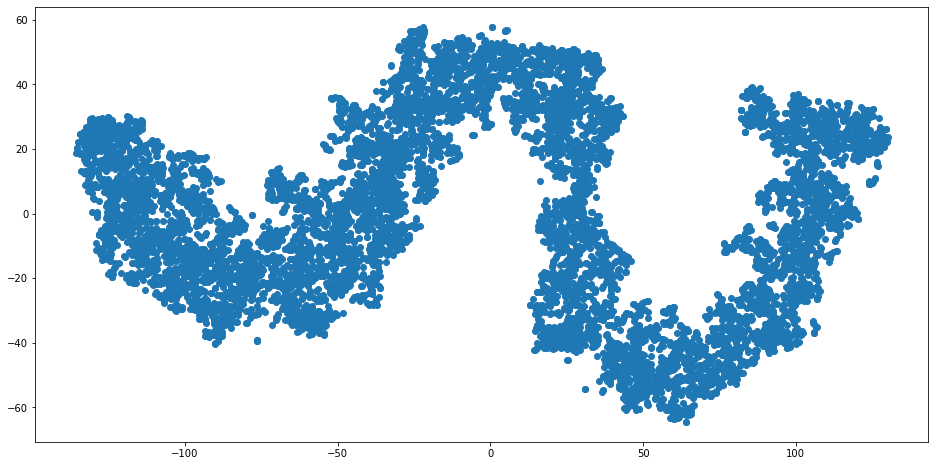

In [15]:
plt.figure(figsize=(16,8))
plt.scatter(xs, ys)
plt.show()

In [16]:
num_clusters = 5

clusterer = KMeansClusterer(num_clusters, euclidean_distance)
clusters = clusterer.cluster(coords, True, trace=True)

k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


In [17]:
clusters

[2,
 3,
 3,
 4,
 3,
 3,
 0,
 0,
 3,
 3,
 3,
 3,
 3,
 1,
 4,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 1,
 3,
 3,
 3,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 4,
 3,
 1,
 1,
 2,
 0,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 0,
 3,
 0,
 3,
 0,
 3,
 2,
 3,
 3,
 3,
 2,
 3,
 1,
 3,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 3,
 1,
 3,
 1,
 3,
 4,
 3,
 0,
 3,
 3,
 1,
 0,
 3,
 1,
 3,
 4,
 2,
 1,
 3,
 1,
 3,
 2,
 1,
 4,
 3,
 0,
 3,
 0,
 3,
 1,
 4,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 1,
 2,
 3,
 4,
 3,
 3,
 1,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 0,
 3,
 3,
 3,
 1,
 0,
 1,
 2,
 3,
 2,
 0,
 1,
 3,
 1,
 0,
 3,
 1,
 4,
 1,
 1,
 3,
 3,
 0,
 0,
 3,
 3,
 1,
 3,
 0,
 2,
 3,
 3,
 0,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 1,
 3,
 3,
 3,
 4,
 1,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 4,
 1,
 1,
 3,
 4,
 3,
 3,
 3,
 3,
 2,
 1,
 3,
 1,
 3,
 1,
 3,
 3,
 3,
 3,
 3,


In [18]:
for i in range(len(coords)):
    print(f'{coords[i]} -- {clusters[i]}')

[-41.507225 -20.317947] -- 2
[124.3812    20.654633] -- 3
[100.2728   -22.451004] -- 3
[-90.75485  -30.919401] -- 4
[122.49294   24.292645] -- 3
[99.62319  26.676283] -- 3
[32.11639   7.022719] -- 0
[-17.131565  20.03406 ] -- 0
[129.70198   22.307568] -- 3
[126.22961   18.877306] -- 3
[105.43758   31.660528] -- 3
[104.50624   26.152847] -- 3
[ 89.78698   -11.3762045] -- 3
[ 23.407404 -38.242485] -- 1
[-122.81199   -16.508448] -- 4
[118.00776    -0.5965512] -- 3
[104.835144  13.569785] -- 3
[114.355736  20.362627] -- 3
[ 37.020008 -32.9573  ] -- 1
[88.79842  23.862434] -- 3
[83.21143  25.152447] -- 3
[121.86271   18.174437] -- 3
[83.98526  35.831017] -- 3
[80.85164  -7.419105] -- 3
[88.899155 29.790396] -- 3
[124.09276  25.0725 ] -- 3
[ 5.2699356 45.71008  ] -- 0
[ 58.3894   -45.848736] -- 1
[114.83278   20.408344] -- 3
[127.38841   21.393986] -- 3
[124.57232   20.916466] -- 3
[ 15.921851 -40.457996] -- 1
[ 15.176965 -40.036377] -- 1
[109.051605  26.360987] -- 3
[105.21766     1.5926231

[103.71346   34.181526] -- 3
[-119.14559      4.9995656] -- 4
[-40.40795    -3.5932372] -- 2
[ 33.36858  -29.641298] -- 1
[104.304955  17.662771] -- 3
[-25.712858  27.876078] -- 0
[-87.2212   -29.534517] -- 4
[115.69447     0.4341932] -- 3
[89.19881 31.27526] -- 3
[ 51.805977 -51.689903] -- 1
[-115.86979     4.799013] -- 4
[ 39.723984 -45.39696 ] -- 1
[17.95256  27.198406] -- 0
[35.23289 30.20799] -- 0
[-105.18737     8.906573] -- 4
[83.86008  30.648716] -- 3
[106.00287  -19.940231] -- 3
[ 76.64844  -47.676414] -- 1
[ 29.123503 -11.603538] -- 1
[101.83628    -2.3707268] -- 3
[ 60.062946 -48.259537] -- 1
[ 42.871857 -51.715706] -- 1
[120.47961  25.93946] -- 3
[92.05767  33.352608] -- 3
[121.92265  32.26956] -- 3
[29.821552 24.450697] -- 0
[84.24967  -5.446971] -- 3
[85.40074  38.934578] -- 3
[127.07047   23.754965] -- 3
[-52.35886    8.563977] -- 2
[-111.36078   -21.211405] -- 4
[103.03187    7.284814] -- 3
[ 97.141754 -34.498837] -- 3
[ 63.91755 -64.53248] -- 1
[ 15.378871 -24.263723] 

[ 28.17013  -11.838654] -- 1
[ 78.02216  -38.323177] -- 1
[-101.37095       0.37029737] -- 4
[-28.304401  53.32633 ] -- 0
[102.86506  -15.801274] -- 3
[-36.67809  24.71171] -- 2
[106.06214   18.472855] -- 3
[100.99109   25.459452] -- 3
[112.42986     1.5916622] -- 3
[126.81364   25.336372] -- 3
[-109.23066   -17.184916] -- 4
[ 81.50465  -33.317818] -- 1
[-73.06199  -21.432838] -- 2
[88.21371   -8.0119295] -- 3
[ 88.82763  -28.805103] -- 3
[-84.63304    -5.1621294] -- 4
[28.611572 18.706646] -- 0
[ 38.609425 -30.837385] -- 1
[ 28.867859 -12.461331] -- 1
[-103.15012     0.417569] -- 4
[ 41.62386  -17.707397] -- 1
[109.17438   21.983545] -- 3
[-36.010914 -19.368162] -- 2
[-118.8626       2.7467709] -- 4
[ 58.50527  -46.423805] -- 1
[ 39.44544  -34.446014] -- 1
[30.473574 13.866139] -- 0
[98.93606   2.369687] -- 3
[ 41.346878 -32.5359  ] -- 1
[-98.875206  -11.0106945] -- 4
[-29.504576  30.281555] -- 0
[121.71321   21.935251] -- 3
[ 99.40481  -17.501781] -- 3
[ 58.59522  -45.236958] -- 1
[ 

[ 88.63585  -24.894196] -- 3
[104.834564 -15.5968  ] -- 3
[ 23.986744 -22.37086 ] -- 1
[94.74355  21.215698] -- 3
[ 4.2781434 49.493877 ] -- 0
[ 15.602586 -29.23105 ] -- 1
[116.08215   24.213478] -- 3
[-2.4037938 36.821995 ] -- 0
[ 89.18133  -40.865723] -- 1
[-31.681002  15.366497] -- 2
[-53.49633  -10.196086] -- 2
[ 72.692665 -52.856514] -- 1
[110.75149     3.9579217] -- 3
[-16.088907  23.49406 ] -- 0
[ 40.53229  -45.893677] -- 1
[ 68.12669 -43.38292] -- 1
[ 88.19409  -28.928312] -- 3
[ 20.79341  -22.970585] -- 1
[30.35096 19.05615] -- 0
[-28.20497   17.529783] -- 2
[ 48.756474 -47.58056 ] -- 1
[ 98.16888 -21.44338] -- 3
[26.129416 49.073605] -- 0
[ 89.47205 -37.36212] -- 1
[ 47.80352 -51.211  ] -- 1
[-37.451733 -20.654242] -- 2
[40.56626  29.128077] -- 0
[16.242798 -4.184558] -- 0
[ 69.34084 -50.26073] -- 1
[ 5.760618 35.646294] -- 0
[ 59.557198 -51.84048 ] -- 1
[-90.06508  -37.579784] -- 4
[ 14.885282 -29.908524] -- 1
[-7.405325 34.4507  ] -- 0
[ 88.64719  -27.866756] -- 3
[ 25.1870

[22.115639 44.83676 ] -- 0
[ 90.6961   -10.923859] -- 3
[88.932236 -8.99589 ] -- 3
[29.756702 21.631964] -- 0
[111.21112   19.495918] -- 3
[20.839445 -7.488629] -- 1
[ 77.47155  -50.425373] -- 1
[-30.439745 -10.544096] -- 2
[ 92.3851   -40.595184] -- 1
[-24.554928   9.20205 ] -- 2
[-117.06232   -15.145232] -- 4
[ 2.1817877 41.572838 ] -- 0
[ 94.715416 -34.770782] -- 3
[ 97.76862  -30.891058] -- 3
[-101.34015  -16.21443] -- 4
[42.116055 30.948606] -- 0
[-42.807907 -26.973648] -- 2
[-23.937     19.658062] -- 0
[ 34.902016 -17.440998] -- 1
[ 98.97615 -23.17733] -- 3
[ 33.25715  -41.241585] -- 1
[19.88104   -3.9964921] -- 0
[ 65.22443  -51.893093] -- 1
[-83.07446  -30.914335] -- 4
[25.43282  39.674137] -- 0
[-104.25009   -14.020054] -- 4
[-12.987719  38.427967] -- 0
[-51.30855   -8.481816] -- 2
[-20.536749  14.076078] -- 0
[ 15.431573 -29.350006] -- 1
[-62.690655 -16.356758] -- 2
[20.56636  23.364527] -- 0
[23.461842 -7.225877] -- 1
[39.31044  28.546768] -- 0
[-84.870575 -31.435009] -- 4
[

[-48.20842  31.0338 ] -- 2
[-98.686066 -19.175909] -- 4
[ 43.73102 -45.79968] -- 1
[ 65.650986 -56.144302] -- 1
[15.691375  -3.7557287] -- 0
[ 49.75848  -56.645424] -- 1
[-78.36271  -31.600061] -- 2
[ 71.05388  -50.288025] -- 1
[-101.83876    -8.301776] -- 4
[-92.66683  -18.136658] -- 4
[-98.85849    6.967417] -- 4
[-58.05741     1.1607414] -- 2
[31.364185  -1.5214877] -- 1
[-30.004005    3.2026887] -- 2
[-93.86916    4.475773] -- 4
[34.519855  5.182918] -- 0
[-116.2217     22.691235] -- 4
[-51.501705 -25.154398] -- 2
[11.148927 50.75893 ] -- 0
[ 90.04487  -27.776121] -- 3
[-113.16366     -0.6077709] -- 4
[-9.497023 29.928165] -- 0
[-131.93602    22.819466] -- 4
[ 60.42592 -57.73005] -- 1
[-54.22631  -26.799532] -- 2
[-124.94513   16.95481] -- 4
[-114.33914    19.986267] -- 4
[39.536114 -9.500955] -- 1
[-25.08007   44.510075] -- 0
[24.709188   0.9376378] -- 0
[-57.56852 -32.91515] -- 2
[-3.5694313 33.11724  ] -- 0
[-46.9204   -19.123388] -- 2
[-41.900524  29.432388] -- 2
[-92.2008     

[-127.62631    26.202984] -- 4
[ 44.056698 -51.579823] -- 1
[27.156895 11.804974] -- 0
[ 40.61785  -21.686584] -- 1
[-30.874651  41.313435] -- 0
[-104.13943   -24.653925] -- 4
[-46.519283 -17.250534] -- 2
[23.764061 -6.816037] -- 1
[-31.26509    -4.2304673] -- 2
[ 32.01727 -37.74026] -- 1
[-57.151997 -34.823772] -- 2
[-40.716896    2.8194823] -- 2
[ 39.065372 -51.51523 ] -- 1
[ 27.786018 -41.65717 ] -- 1
[ 38.09978 -45.39303] -- 1
[-122.142365   14.746011] -- 4
[ 27.426102 -40.547104] -- 1
[ 37.473125 -16.41915 ] -- 1
[ 71.8036  -38.37051] -- 1
[100.321526 -17.48941 ] -- 3
[-54.277733   7.127317] -- 2
[ 73.641716 -30.915876] -- 1
[93.45181   8.456334] -- 3
[-77.74277  -14.280043] -- 2
[-100.81685      3.6495645] -- 4
[-62.183113 -34.355843] -- 2
[ 46.967663 -35.711243] -- 1
[-131.75005    10.358839] -- 4
[-54.58938    9.690657] -- 2
[26.574224 35.704144] -- 0
[-52.908268    2.3244195] -- 2
[-93.25416   10.611429] -- 4
[-11.786953  45.076756] -- 0
[-67.49685  -21.423805] -- 2
[ 56.23822

[-87.75926    -6.7089763] -- 4
[17.395004 50.04965 ] -- 0
[-84.89465  -22.968771] -- 4
[31.997238 37.14558 ] -- 0
[-18.817595  12.859907] -- 0
[ 36.81743  -50.375187] -- 1
[-3.2568264 49.97326  ] -- 0
[-72.358696   -5.5712905] -- 2
[-126.743774   15.428695] -- 4
[-57.268276 -32.27044 ] -- 2
[-115.063995    -1.5939668] -- 4
[-124.176094   -5.823458] -- 4
[-113.25586    15.087125] -- 4
[-68.061356  -5.065219] -- 2
[ 48.65738 -45.92977] -- 1
[-120.90906     -1.0575566] -- 4
[-112.67486     -4.0875044] -- 4
[ 29.452307 -33.5182  ] -- 1
[-35.58375   23.768333] -- 2
[-112.90507    15.826837] -- 4
[-34.039154 -14.857885] -- 2
[-99.18696  -23.169691] -- 4
[-67.10426  -10.835082] -- 2
[-21.311838  26.275282] -- 0
[104.86767   -5.874471] -- 3
[ 39.357227 -46.072086] -- 1
[27.411442   3.6573012] -- 0
[ 97.668236 -26.188238] -- 3
[-48.902447 -15.248313] -- 2
[ 37.39939  -45.971973] -- 1
[17.38331 33.03331] -- 0
[ 98.64236  -25.798508] -- 3
[21.048388 16.825521] -- 0
[18.084618 50.994656] -- 0
[ 54

[14.345912 29.57069 ] -- 0
[-110.87268    21.402386] -- 4
[-101.789566   11.807892] -- 4
[ 6.5144672 50.918774 ] -- 0
[-121.14118     -3.9859688] -- 4
[-72.57845    -5.0560217] -- 2
[-123.1504       9.6790905] -- 4
[-3.7443504 36.294548 ] -- 0
[29.413363 41.131615] -- 0
[18.706066 43.32712 ] -- 0
[23.197948 50.620365] -- 0
[-24.09208   14.283391] -- 2
[-112.883575   21.168205] -- 4
[-107.860085   21.01951 ] -- 4
[-109.03589    17.803076] -- 4
[-108.02095    21.051777] -- 4
[-110.293526   22.11708 ] -- 4
[-86.346275   -6.3330503] -- 4
[-62.80858  -11.312367] -- 2
[-86.2695   -16.629747] -- 4
[ 50.019352 -50.62128 ] -- 1
[-37.376064 -10.101533] -- 2
[31.049692 41.763123] -- 0
[-117.98644    19.091856] -- 4
[-132.37274     9.052998] -- 4
[-130.48283    26.926323] -- 4
[-18.5054    37.983814] -- 0
[-119.0156      9.131082] -- 4
[-66.30988  -22.427864] -- 2
[-32.789062  -9.724969] -- 2
[25.229479 38.217674] -- 0
[-2.3058274 46.253437 ] -- 0
[-22.394396  12.989615] -- 2
[-63.619595 -24.28546

[-125.90764    21.869476] -- 4
[-118.83441      2.7443633] -- 4
[-78.423035 -22.467358] -- 2
[-115.55247    15.138686] -- 4
[-125.582924   18.138432] -- 4
[-129.49638    24.803318] -- 4
[-36.142323  26.43788 ] -- 2
[-69.23964   11.733415] -- 2
[-98.927185  17.269655] -- 4
[-46.174213  20.345291] -- 2
[-72.19162    9.667996] -- 2
[-99.69232    -3.2348347] -- 4
[-135.13379   20.30727] -- 4
[-49.56698  22.88701] -- 2
[-46.450287   -3.1639433] -- 2
[29.723938  -7.9478755] -- 1
[-38.708687  27.796446] -- 2
[-112.79262  -12.51026] -- 4
[-105.519455    8.379234] -- 4
[-108.27919    -7.169865] -- 4
[-46.095524  -6.034245] -- 2
[26.987505   -0.56885344] -- 0
[20.696388 -7.428567] -- 1
[13.364613 23.504784] -- 0
[-60.8906      0.7787559] -- 2
[-122.729164   20.956598] -- 4
[-86.251434 -19.041723] -- 4
[-5.9979177 46.76299  ] -- 0
[16.540697 -5.043758] -- 0
[-124.257774   17.366573] -- 4
[ 6.0864563 45.048546 ] -- 0
[22.790981 12.384019] -- 0
[-71.8958   -20.868624] -- 2
[-125.37234     -3.490719

[-65.00875  -31.428793] -- 2
[ 48.540424 -60.50963 ] -- 1
[ 33.140663 -39.27888 ] -- 1
[-9.513548 52.881813] -- 0
[-62.74715   11.038874] -- 2
[-73.35536   -9.486914] -- 2
[-130.15794    23.492895] -- 4
[-132.63527    19.493889] -- 4
[-50.34897  -19.491356] -- 2
[-8.569538 51.490067] -- 0
[-35.5218    -3.737913] -- 2
[-83.43872  -20.389416] -- 4
[-88.79052    -2.2823892] -- 4
[-22.798529  22.80502 ] -- 0
[-113.91615     5.893555] -- 4
[-125.96118    29.419315] -- 4
[23.411856 42.179832] -- 0
[-30.95064   13.293318] -- 2
[-120.83129    20.022106] -- 4
[-26.750566   -7.7290072] -- 2
[-116.506325    -3.3871167] -- 4
[ 2.7085624 50.034847 ] -- 0
[-8.210549 43.055584] -- 0
[-57.238945    3.8705826] -- 2
[-89.81546  -17.863554] -- 4
[-93.48207      0.53577226] -- 4
[-43.5816     9.699766] -- 2
[27.810217 17.896643] -- 0
[-100.422745   11.88709 ] -- 4
[-117.39836    -6.145282] -- 4
[-132.27895    20.085442] -- 4
[-82.00508  -26.728134] -- 4
[-32.170082    6.0194864] -- 2
[-36.58077     1.3210

Make a dictionary where each cluster is a key. This will make it easier to plot the clusters

In [19]:
clustered_coords = {}

for i in range(num_clusters):
    clustered_coords.update({i: [c for j, c in enumerate(coords) if clusters[j] == i]})
    
clustered_coords

{0: [array([32.11639 ,  7.022719], dtype=float32),
  array([-17.131565,  20.03406 ], dtype=float32),
  array([ 5.2699356, 45.71008  ], dtype=float32),
  array([13.18309 , 36.414562], dtype=float32),
  array([-27.799791,  42.088783], dtype=float32),
  array([-10.672966,  18.543043], dtype=float32),
  array([35.29415 , 23.521858], dtype=float32),
  array([30.798443 ,  3.4949107], dtype=float32),
  array([-12.153967,  16.549139], dtype=float32),
  array([-5.4833937, 40.64112  ], dtype=float32),
  array([-9.76889 , 32.405193], dtype=float32),
  array([-22.474054,  54.307934], dtype=float32),
  array([-28.582268,  46.54311 ], dtype=float32),
  array([19.67629 , 15.555804], dtype=float32),
  array([22.832209, 27.37029 ], dtype=float32),
  array([19.95693, 29.39509], dtype=float32),
  array([10.546474, 43.72223 ], dtype=float32),
  array([13.925898, 34.337055], dtype=float32),
  array([30.340279, 12.327092], dtype=float32),
  array([ 2.9276714, 43.041225 ], dtype=float32),
  array([ 7.751389,

Plot the clusters

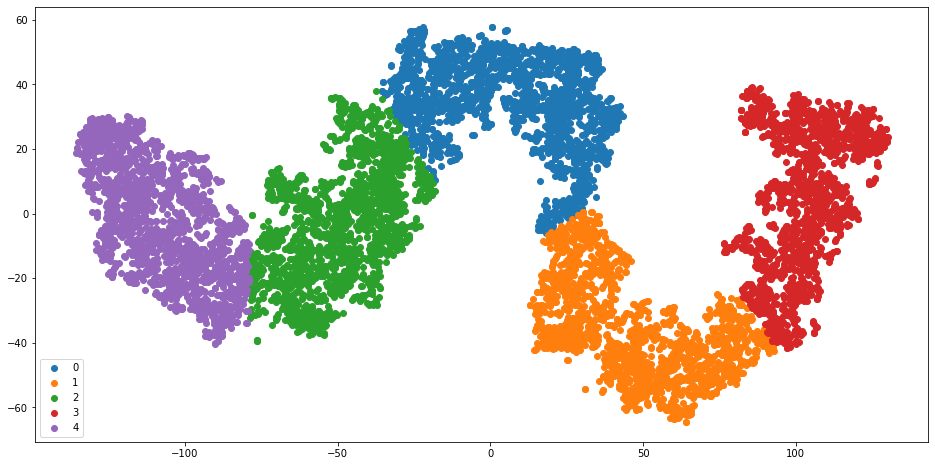

In [20]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(111)

for key in clustered_coords.keys():
    cluster = clustered_coords[key]
    
    xs = []
    ys = []
    
    for c in cluster:
        xs.append(c[0])
        ys.append(c[1])
        
    ax.scatter(xs, ys, label=str(key))

ax.legend(loc='lower left')
plt.show()

### Next, I look at what words show up in each cluster.
Since the clusters array should still be parallel to the vocabulary, I can just make a dictionary with those.

In [21]:
cluster_dict = {}

for i, word in enumerate(vec.wv.vocab):
    cluster_dict.update({word: (coords[i], clusters[i])})

cluster_dict

{'brave': (array([-41.507225, -20.317947], dtype=float32), 2),
 'u.s.': (array([124.3812  ,  20.654633], dtype=float32), 3),
 'army': (array([100.2728  , -22.451004], dtype=float32), 3),
 'lieutenant': (array([-90.75485 , -30.919401], dtype=float32), 4),
 'general': (array([122.49294 ,  24.292645], dtype=float32), 3),
 'may': (array([99.62319 , 26.676283], dtype=float32), 3),
 'career': (array([32.11639 ,  7.022719], dtype=float32), 0),
 'resist': (array([-17.131565,  20.03406 ], dtype=float32), 0),
 'trump': (array([129.70198 ,  22.307568], dtype=float32), 3),
 'administration': (array([126.22961 ,  18.877306], dtype=float32), 3),
 'efforts': (array([105.43758 ,  31.660528], dtype=float32), 3),
 'war': (array([104.50624 ,  26.152847], dtype=float32), 3),
 'iran': (array([ 89.78698  , -11.3762045], dtype=float32), 3),
 'robert': (array([ 23.407404, -38.242485], dtype=float32), 1),
 'p.': (array([-122.81199 ,  -16.508448], dtype=float32), 4),
 'white': (array([118.00776  ,  -0.5965512],

In [22]:
clust0 = [key for key in cluster_dict.keys() if cluster_dict[key][1] == 0]
clust1 = [key for key in cluster_dict.keys() if cluster_dict[key][1] == 1]

In [23]:
for i in range(num_clusters):
    clust = [key for key in cluster_dict.keys() if cluster_dict[key][1] == i]
    print(f'Cluster {i}:')
    print(clust)
    print()

Cluster 0:
['career', 'resist', 'memo', 'conflict', 'israelis', 'benjamin', 'elements', 'primary', 'iraqi', 'genuine', 'argue', 'atalanta', 'bergamo', 'milan', 'fans', 'valencia', 'pointing', 'feb.', 'biological', 'specialist', 'locally', 'definitely', 'peace', 'televised', 'trucks', 'neighboring', 'count', 'mild', 'moderate', 'competition', 'governing', 'del', 'clubs', 'di', 'buses', 'player', 'alarming', 'athletes', 'stuck', 'teams', 'thousand', 'mention', 'choices', 'actual', "'ll", 'lying', 'factor', 'drawing', 'angry', 'ally', 'swathes', 'desire', 'reviewed', 'urgently', 'relies', 'household', 'assist', 'agreements', 'engineering', 'depleted', 'stepped', 'contribution', 'recalled', 'faulty', 'procedures', 'health-care', 'contracting', '30,000', 'sets', '50,000', 'pairs', 'shipment', 'supplier', 'strained', 'differences', 'critically', 'beach', 'photographs', 'waves', 'locals', 'indoors', 'grows', 'protects', 'eggs', 'length', 'english', 'types', 'emerge', 'exact', 'extraordinary',